## Drawing the SSTs

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import networkx as nx 
import pandas as pd
import sys; sys.path.append('../')
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

In [4]:
def load_pickle(fname):
    return pkl.load(open(fname, 'rb'))

# Test Results

These directories contain results from AUC and AUPR scores for link prediction tasks. (Results produced by runner.py)

The directory structure mirrors that of the `evaluation_data_splits/` folder. See the Readme in `evaluation_data_splits/` for more information on the directory structure.


### For SSTS:

The pickle file will contain a list of (weight, subgraph-subgraph transition) pairs in order of decreasing magnitude of weight.

The "weight" is a component of the (unit) direction vector from a linear SVM separating non-changes from changes. Thus, the larger a weight, the more that particular SST indicates a change, and smaller (i.e. a "larger" negative) a weight the more it indicates a non-change.

An SST is represented as a four-tuple: `(Node Highlights, Node Traits, Edge List, Edge Traits)`

 - Node Highlights indicates which nodes are the ones involved in the change.
    - For node additions, the new node has a highlight of `0` and other nodes have `None`.
    - For edge additions, the source node has a hightlight of `0` and the target has `0` if undirected and `1` if directed. Other nodes have `None`
    - Node deletions and edge deletions correspond to their respective additions.
- Node Traits indicates any trait values nodes have. For more information on node traits, check out the documentation in `graph_change_feature_counts.py`
    - In the link-prediction experiments performed in this repository, there is one node trait: `InvNode Degree`
        - InvNode Degree is only used in static, undirected link prediction.
        - It states which of the two nodes being connected, if either, has a higher degree.
- Edge List has a list of the edges in the subgraph.
    - If edges for a node or edge addition, includes all the edges after the SST is completed
    - If edges for a node or edge deletion, includes all the edges before the SST is completed
- Edge Traits -- same as Node Traits but for edges
    - In the link-prediction experiments performed in this repository, there are two edge traits: `TLP: Freq` and `TLP: Recency` (`temporal_link_pred_traits.py`)
        - `TLP: Freq` indicates how many timestamps an edge (i.e. interaction) has occurred before it occurred in the current SST
            - Possible values are "0" (this is the first time this interaction occurred), "1", "2", "3+" (indicating 3 or more prior occurrences)
            - *After* the SST is completed (i.e. after the edge is added), the new edge will update its value (e.g. from "0" to "1" or "3+" to "3+").
        - `TLP: Recency` indicates how recently an edge (i.e. interaction) occured before it occurred in the current SST
            - Possible values are "Never" (this is the first time this interaction occurred), "Newest" (it occured in the previous timestamp), "New" (it occurred in the timestamp before the last), and "Old" (Latest prior occurrence was at least 3 timestamps ago)
            - *After* the SST is completed (i.e. after the edge is added), the new edge will update its value to "Newest", and any edges not added by some SST will "age" (e.g. "Newest" -> "New", "Old" -> "Old")


In [201]:
def draw_sst(sst, is_directed=False, is_temporal=False, ax=None):
    score = sst[0]
    sst = sst[1]
    
    graph = nx.DiGraph() if is_directed else nx.Graph()
    
    new_nodes = []
    for i, n in enumerate(sst[1]):
        if n == 0:
            new_nodes.append(i)

    edges = sst[5]
    graph.add_edges_from(edges)
    
    new_edges = graph.subgraph(new_nodes).edges()
    
    if score < 0:
        ax.set_facecolor('#ffebea')
    else:
        ax.set_facecolor('#e5f8e5')
    
    ax.set_title(f'{round(score, 3)}')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
#     pos = nx.nx_agraph.graphviz_layout(graph)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos=pos, node_color='gray', ax=ax)
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=new_nodes, node_color='#aec6cf', ax=ax)
    nx.draw_networkx_edges(graph, pos=pos, edge_color='gray', ax=ax, arrowsize=20)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=new_edges, edge_color='black', arrowsize=20,
                           ax=ax)
    return

In [208]:
def draw_all_sst(ssts, is_directed=False, is_temporal=False, name=''):
    nrows = 3 if is_directed else 2
    ncols = min(6, len(ssts)// nrows)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    plt.rcParams['figure.figsize'] = (20, 7)
    for ax, sst in zip(axes.flatten(), ssts):
        draw_sst(sst, is_directed=is_directed, is_temporal=is_temporal, ax=ax)
    plt.tight_layout()
    plt.suptitle(name, y=1.05)

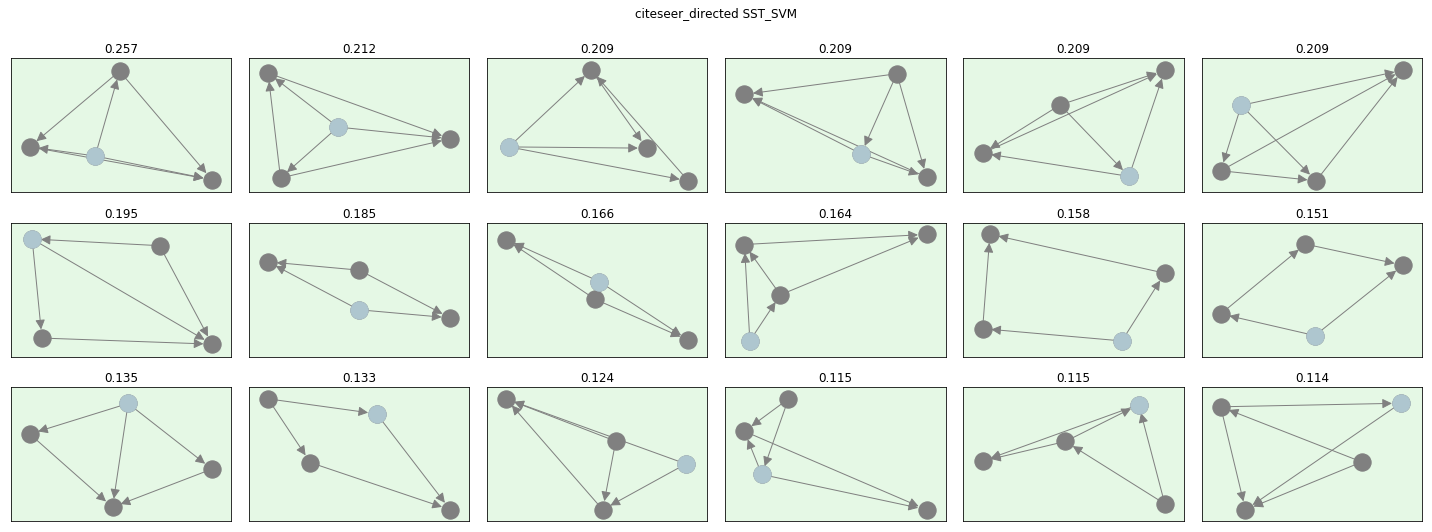

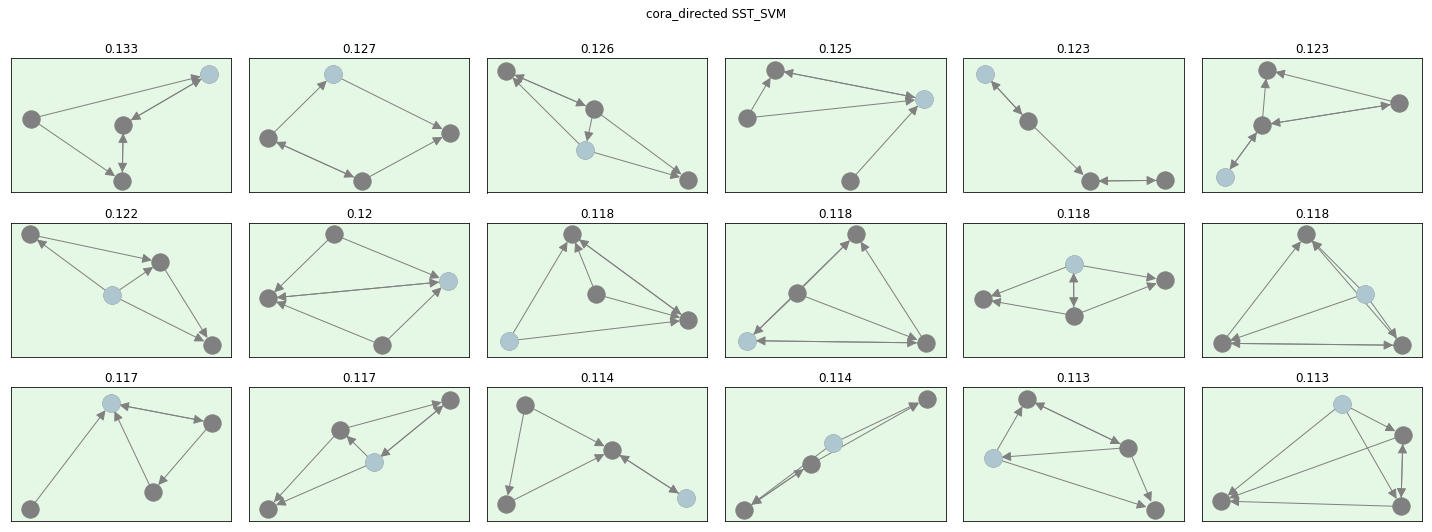

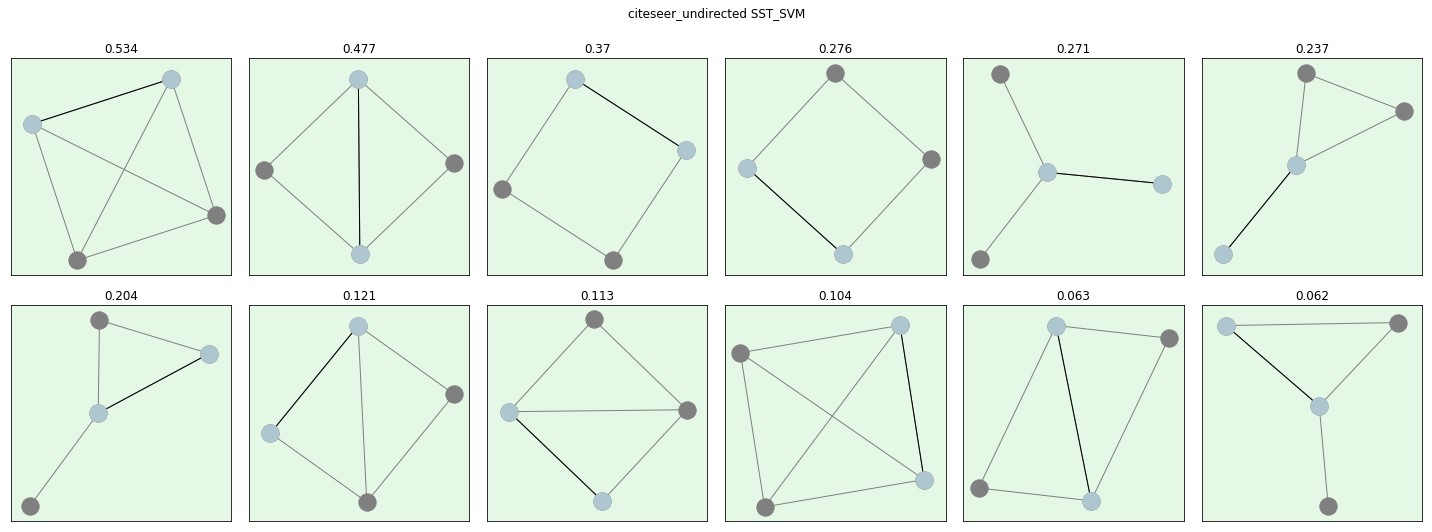

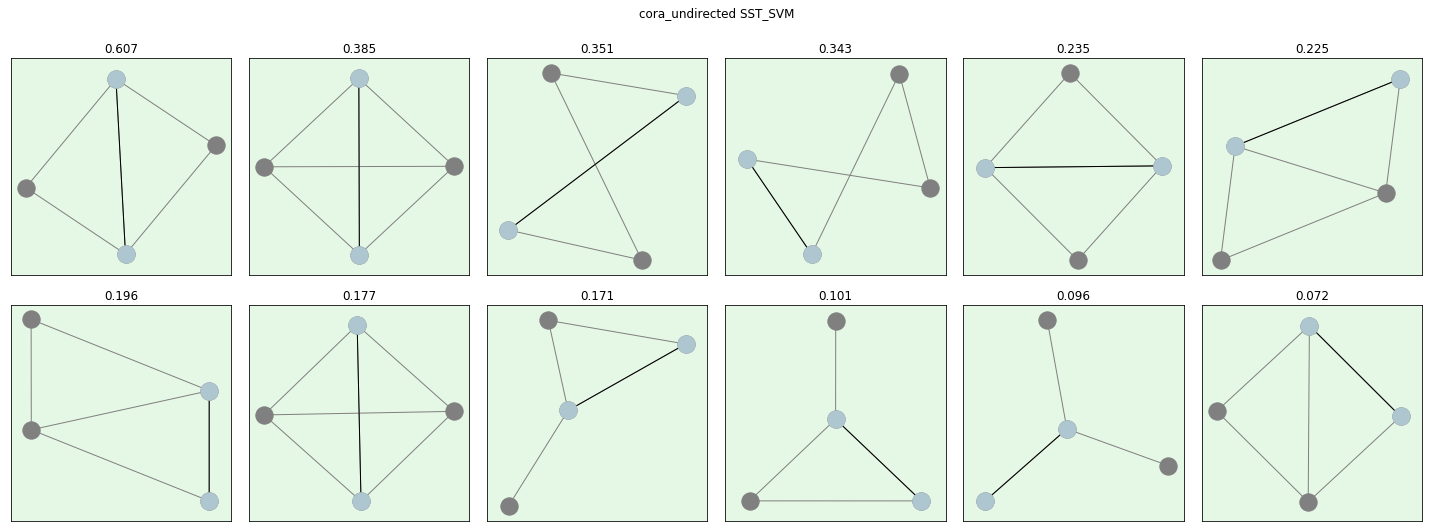

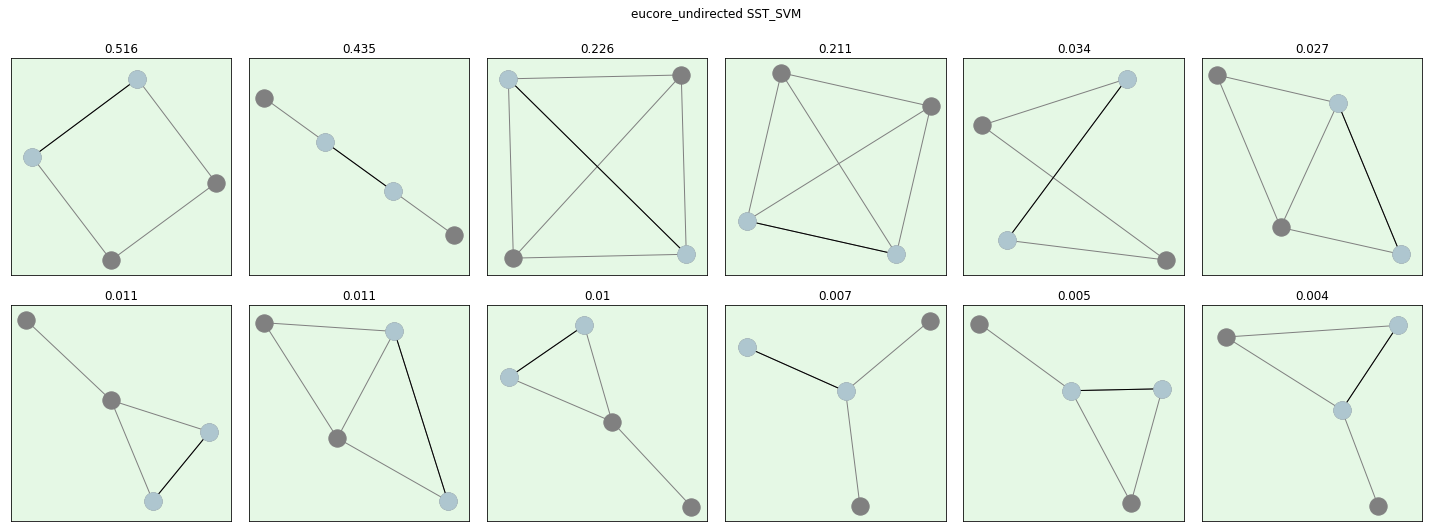

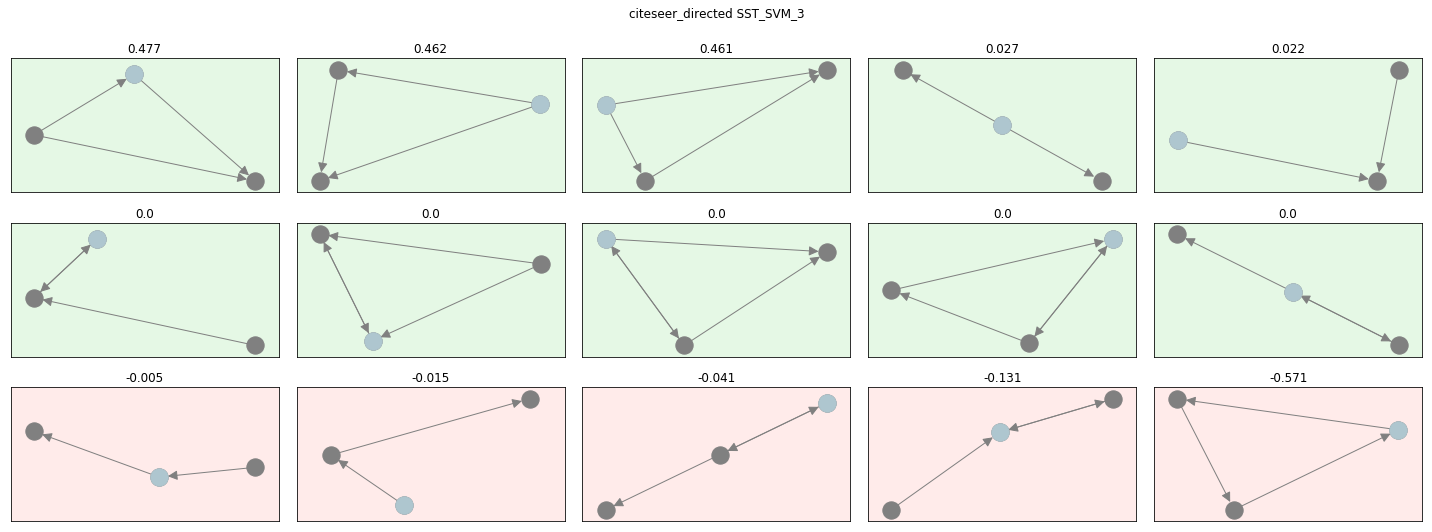

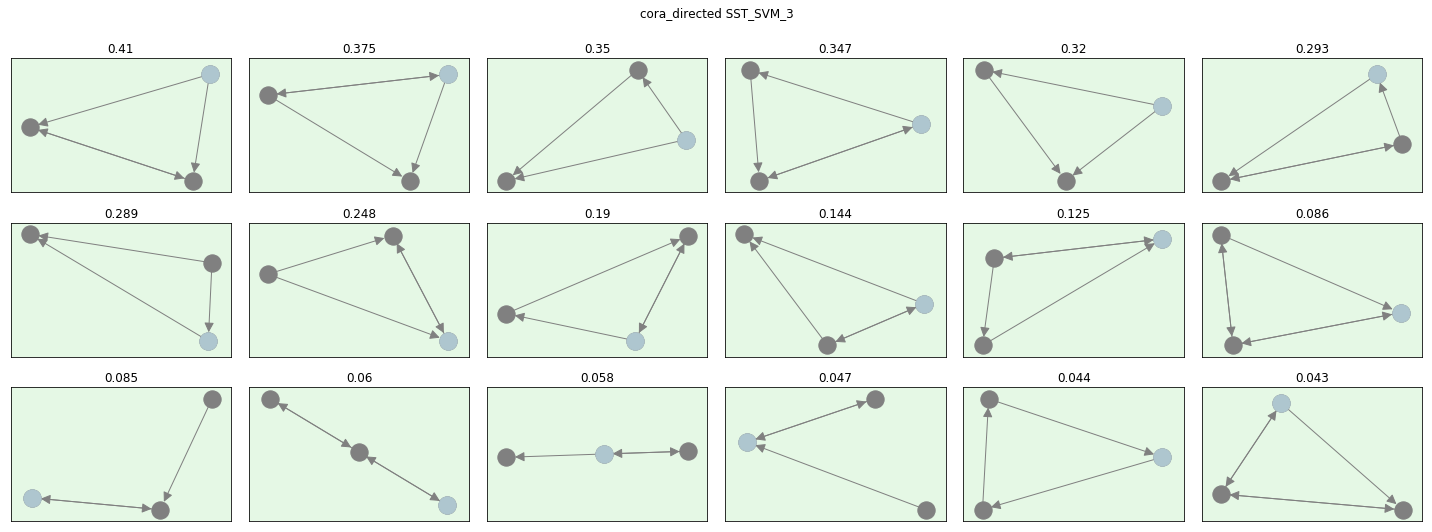

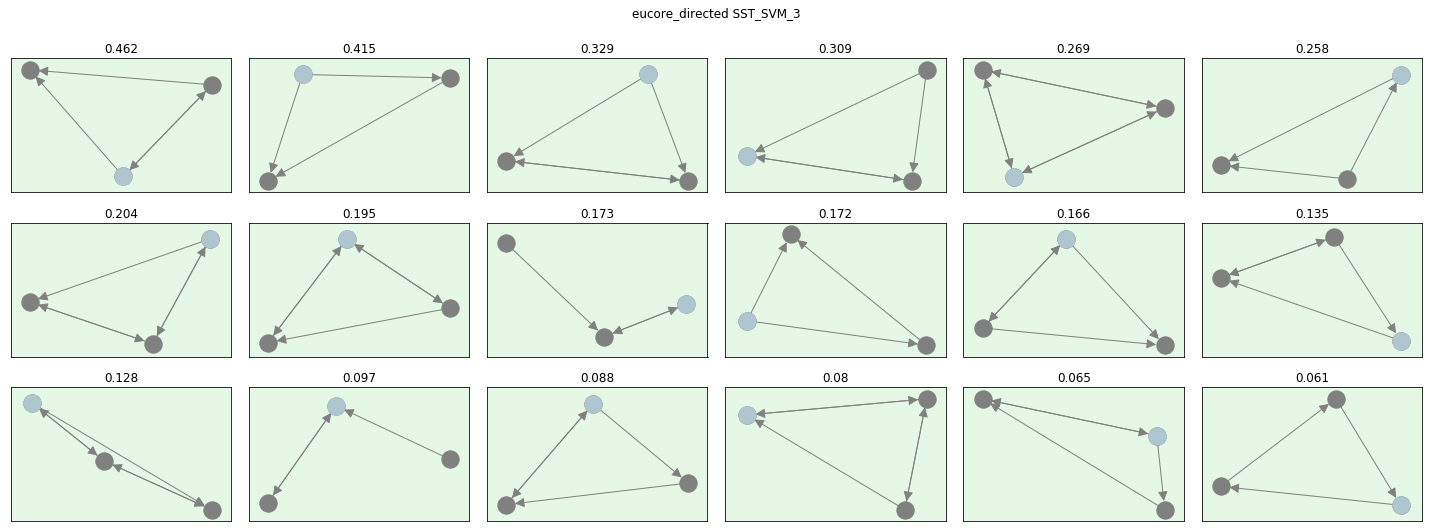

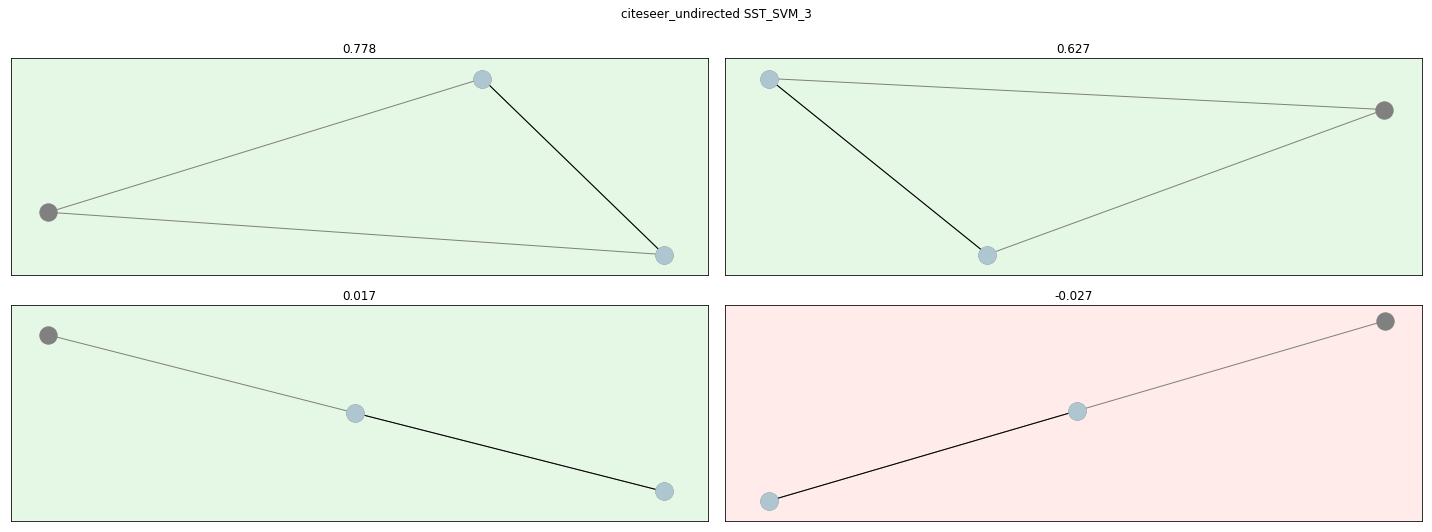

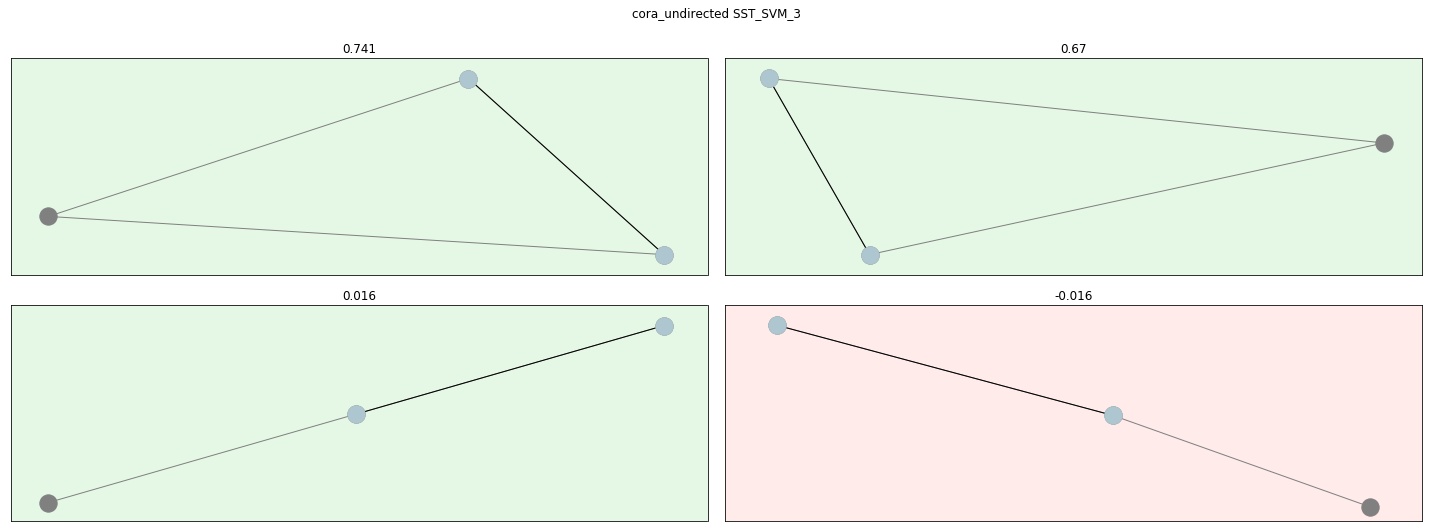

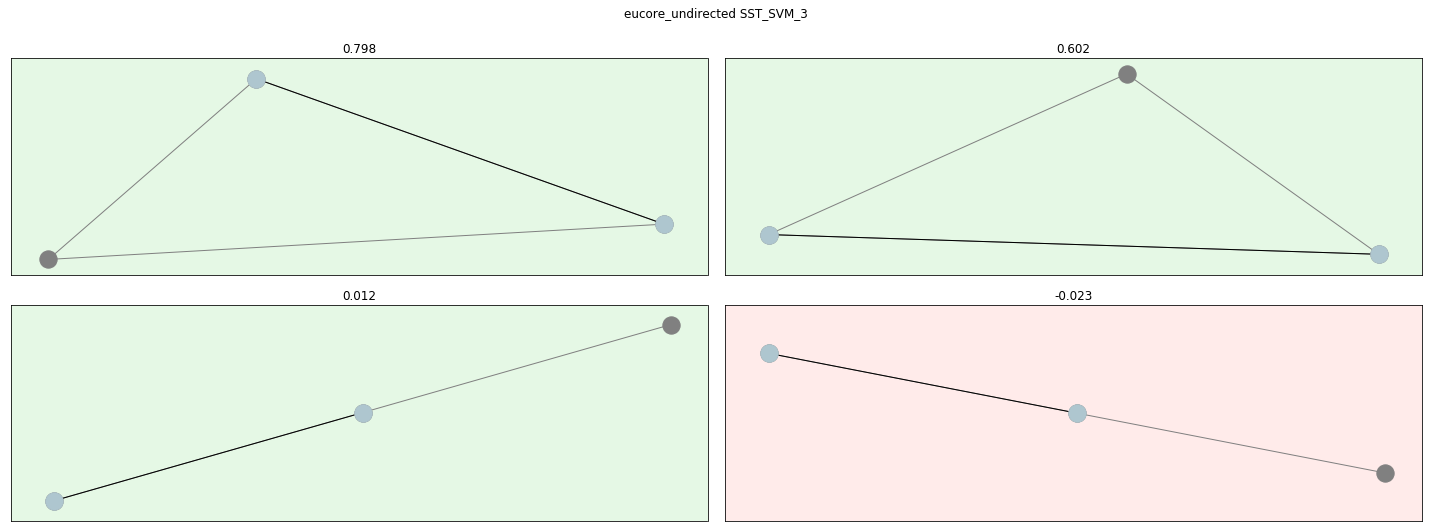

In [216]:
# dataset = 'citeseer'
# is_directed, is_temporal = True, False
# model = 'SST_SVM_3'

is_temporal = False

for model in 'SST_SVM', 'SST_SVM_3':
    for is_directed in (True, False):
        for dataset in 'citeseer', 'cora', 'eucore':
            dataset = f'{dataset}_directed' if is_directed else f'{dataset}_undirected'
            temporal = 'temporal' if is_temporal else 'static'
            
            try:
                ssts = load_pickle(f'../test_results/{temporal}/{dataset}/{model}_ssts_1.pkl')
            except FileNotFoundError:
                continue
            ssts = sorted(ssts, key=lambda x: x[0], reverse=True)

            draw_all_sst(ssts, name=f'{dataset} {model}', is_directed=is_directed)
            plt.savefig(f'./plots/SSTs/{dataset}_{model}.png', dpi=500, bbox_inches='tight')

In [161]:
sst = ssts[0][1]
# display(sst)
new_nodes = []
for i, n in enumerate(new_nodes):
    if n == 0:
        new_nodes.append(i)

[0, 0]